# How to train and tune a random forest

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('white')
np.random.seed(seed=42)

In [5]:
results_path = Path('results', 'random_forest') #设置结果存放路径
if not results_path.exists(): 
    results_path.mkdir(parents=True)

## Get Data

In [6]:
with pd.HDFStore('data.h5') as store:
    data =store['us/equities/monthly']
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73506 entries, ('A', Timestamp('2007-11-30 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            73506 non-null  float64
 1   bb_down        73506 non-null  float64
 2   bb_high        73506 non-null  float64
 3   bb_low         73506 non-null  float64
 4   bb_mid         73506 non-null  float64
 5   bb_up          73506 non-null  float64
 6   macd           73506 non-null  float64
 7   natr           73506 non-null  float64
 8   rsi            73506 non-null  float64
 9   sector         73506 non-null  object 
 10  return_1m      73506 non-null  float64
 11  return_3m      73506 non-null  float64
 12  return_6m      73506 non-null  float64
 13  return_12m     73506 non-null  float64
 14  beta           73506 non-null  float64
 15  SMB            73506 non-null  float64
 16  HML            7350

In [7]:
y = data.target
y_binary = (y > 0).astype(int) #将y变成分类变量
X = pd.get_dummies(data.drop('target', axis=1)) #对特征变量进行哑变量编码

In [8]:
X.info()  

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73506 entries, ('A', Timestamp('2007-11-30 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   atr                           73506 non-null  float64
 1   bb_down                       73506 non-null  float64
 2   bb_high                       73506 non-null  float64
 3   bb_low                        73506 non-null  float64
 4   bb_mid                        73506 non-null  float64
 5   bb_up                         73506 non-null  float64
 6   macd                          73506 non-null  float64
 7   natr                          73506 non-null  float64
 8   rsi                           73506 non-null  float64
 9   return_1m                     73506 non-null  float64
 10  return_3m                     73506 non-null  float64
 11  return_6m                     73506 non-null

## Random Forests

### Cross-validation parameters

In [9]:
n_splits = 10  #10折交叉验证
train_length = 60  #训练集大小
test_length = 6  #测试集大小
lookahead = 1 #测试集与训练集之间留出间隔

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_length,
                          test_period_length=test_length,
                          lookahead=lookahead)

### Classifier

In [10]:
rf_clf = RandomForestClassifier(n_estimators=100,    # 决策树的数量 
                                criterion='gini',    # 分裂节点所用的标准
                                max_depth=None,      #树的最大深度。如果为None，则将节点展开，直到所有叶子都包含少于min_samples_split个样本
                                min_samples_split=2,    #拆分内部节点所需的最少样本数
                                min_samples_leaf=1,     #在叶节点处需要的最小样本数，仅在任何深度的分割点在左分支和右分支中的每个分支上至少留下min_samples_leaf个训练样本时，才考虑
                                min_weight_fraction_leaf=0.0,  #所有叶节点处（所有输入样本）的权重总和中的最小加权分数
                                max_features='auto',  #如果为“auto”，则max_features = sqrt（n_features）寻找最佳分割时考虑的特征数量
                                max_leaf_nodes=None,  #最大叶子节点数，整数，默认为None
                                min_impurity_decrease=0.0,  #决策树生长的最小纯净度
                                min_impurity_split=None,  
                                bootstrap=True, #将每次有放回地随机选取样本
                                oob_score=True,  #得到集成的评估
                                n_jobs=-1, 
                                random_state=42, 
                                verbose=1)

#### Cross-Validation with default settings

In [11]:
cv_score = cross_val_score(estimator=rf_clf, #模型
                           X=X,
                           y=y_binary,
                           scoring='roc_auc', #scoring方法
                           cv=cv, #交叉验证生成器
                           n_jobs=-1, #n_jobs=-1表示使用CPU所有的线程数进行运算，起到并行加速的作用
                           #The -1 value uses all available cores.
                           verbose=1) #输出进度条

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   24.1s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.6s finished


In [12]:
np.mean(cv_score) #交叉验证得分均值

0.5194286013259808

### Regression RF

In [13]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0] #计算y、y预测值的秩相关系数

ic = make_scorer(rank_correl)  #接受一个评分函数，返回对于估计器的评分
#信息系数

In [14]:
rf_reg = RandomForestRegressor(n_estimators=100, 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False)

In [15]:
cv_score = cross_val_score(estimator=rf_reg,
                           X=X,
                           y=y,
                           scoring=ic,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.5min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


In [16]:
np.mean(cv_score)

0.01281250838919747

## Parameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb). 

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail). 
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

### Define Parameter Grid

In [17]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}  #定义参数网格

### Instantiate GridSearchCV

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [18]:
gridsearch_clf = GridSearchCV(estimator=rf_clf, #所使用的估计器
                              param_grid=param_grid, #参数网格                                      
                              scoring='roc_auc',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

### Fit Classifier

In [19]:
gridsearch_clf.fit(X=X, y=y_binary) #利用选择最优参数拟合模型

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.4s finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x00000251AB2DE648>,
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              o

#### Persist Result

In [20]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib') 
#一般用来训练模型的过程比较长，所以我们一般会将训练的模型进行保存(持久化)，然后进行评估，预测等等，这样便可以节省大量的时间

['results\\random_forest\\gridsearch_clf.joblib']

In [21]:
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib')  #加载

In [22]:
gridsearch_clf.best_params_ #最优参数

{'max_depth': 15, 'min_samples_leaf': 100, 'n_estimators': 50}

In [23]:
gridsearch_clf.best_score_ 

0.5231700482953212

#### Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

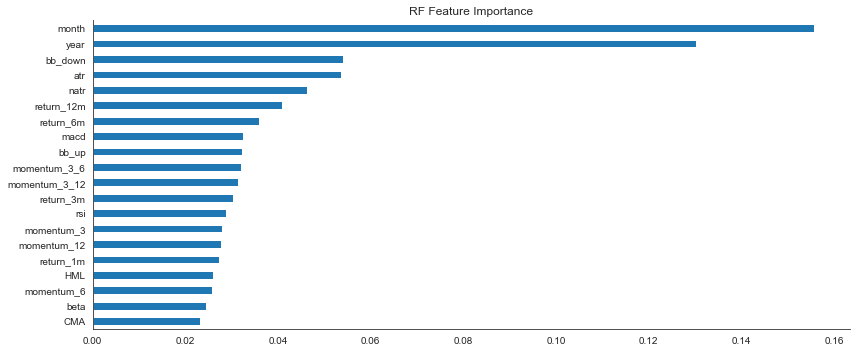

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, #对特征重要性度量的标准化
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]    #前20个重要的特征
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout(); #the top 15 features for both models

### Fit Regressor

In [25]:
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                      cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [26]:
gs_reg = gridsearch_reg

In [30]:
gridsearch_reg.fit(X=X, y=y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 51.7min finished


GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x00000251AB2DE648>,
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                           

In [31]:
joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib') 

['results\\random_forest\\rf_reg_gridsearch.joblib']

In [32]:
gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib') 

In [33]:
gridsearch_reg.best_params_

{'max_depth': 5, 'min_samples_leaf': 25, 'n_estimators': 50}

In [34]:
f'{gridsearch_reg.best_score_*100:.2f}'

'5.71'

### Compare Results

In [35]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,5,15
min_samples_leaf,25,100
n_estimators,50,50


#### Feature Importance

#### Best Parameters

In [36]:
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_

In [37]:
idx = [c.replace('_', ' ').upper() for c in X.columns]

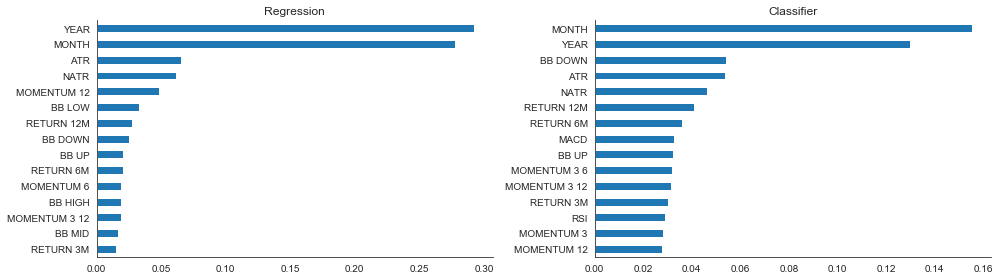

In [38]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)  #各个特征的feature importance
(pd.Series(fi_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
sns.despine()
fig.tight_layout()